Rice Leaf Disease Detection


In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-python

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Loading the Data

In [2]:
EPOCHS = 25
BS = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = 'C:\\Users\\STANDARD\\OneDrive\\Documents\\PROJECT DS\\Rice leaf\\Data'
width=64
height=64
depth=3

### Testing the images are correctly loaded

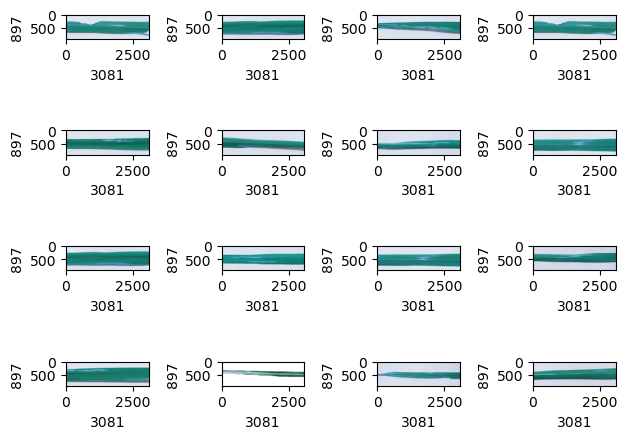

In [35]:
import random
import os
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    path='C:\\Users\\STANDARD\\OneDrive\\Documents\\PROJECT DS\\Rice leaf\\Data\\Bacterial leaf blight'
    rand_img = cv2.imread(path+'\\'+random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1],fontsize=10)#width of image
    plt.ylabel(rand_img.shape[0],fontsize=10)#height of image

### Data Preprocessing 

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

            for image in plant_disease_folder_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [6]:
import pandas as pd
unique_val= np.unique(label_list)
count = pd.DataFrame(label_list).value_counts()
print(unique_val)
print(count)

['Bacterial leaf blight' 'Brown spot' 'Leaf smut']
Bacterial leaf blight    1600
Brown spot               1600
Leaf smut                1521
Name: count, dtype: int64


In [7]:
image_size = len(image_list)
image_size

4721

### Converting the image classes to binary form 

In [11]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [12]:
image_list[0].shape

(64, 64, 3)

In [13]:
print(label_binarizer.classes_)

['Bacterial leaf blight' 'Brown spot' 'Leaf smut']


In [14]:
 # normalizing the dataset as the image pixel will be ranging from 0 to 255 so will be dividing each image by 255to scale it to 0 to 1 range
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [34]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [39]:
y_train.shape

(3776, 3)

In [35]:
# Creating the neural network with the multiple hidden layer containing various methods
from keras import backend as K
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 21, 21, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 10, 10, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,564,419 (13.60 MB)

 Trainable params: 3,561,539 (13.59 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [37]:
from tensorflow.keras.optimizers import Adam
opt = Adam(0.0001)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [43]:
# Fitting the model with the batch size as 30 and epoch as 50 
history = model.fit(x_train,y_train,batch_size=30,
                    epochs=50,validation_data=(x_train, y_train))

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 198ms/step - accuracy: 0.9910 - loss: 0.0281 - val_accuracy: 1.0000 - val_loss: 6.4693e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.9910 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 192ms/step - accuracy: 0.9968 - loss: 0.0138 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 205ms/step - accuracy: 0.9971 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 213ms/step - accuracy: 0.9937 - loss: 0.0190 - val_accuracy: 1.0000 - val_loss: 2.7701e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 194ms/step - accuracy: 0.9951 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 3.2717e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.9968 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 1.7933e-04
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 

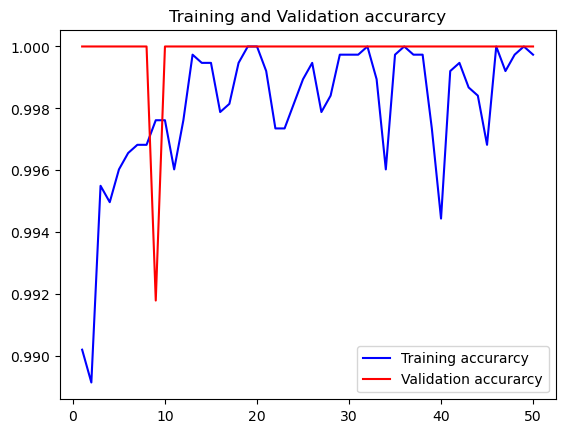

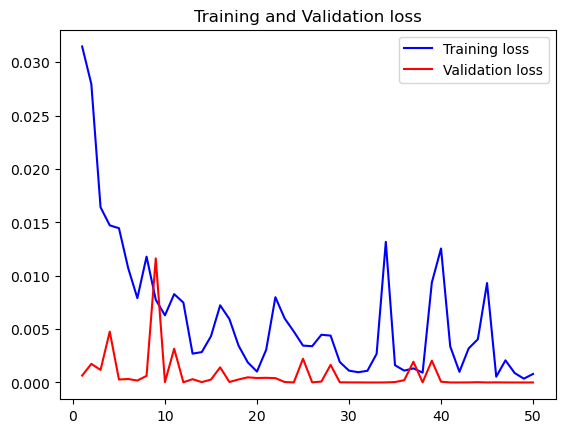

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [45]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 1.0000 - loss: 5.4885e-07
Test Accuracy: 100.0


In [46]:
y_pred= model.predict(x_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


In [51]:
# Chooosing a random image to verify if the model is able to predict correctly
from tensorflow.keras.preprocessing.image import array_to_img
img= array_to_img(x_test[12])

In [53]:
#Finding the max value from the predicted list and comapring it with the original and predicted
print("original_label:",label_list[np.argmax(y_test[12])])
print("predicted_label:",label_list[np.argmax(y_pred[12])])
print(y_pred[2])

original_label: Bacterial leaf blight
predicted_label: Bacterial leaf blight
[1.0000000e+00 1.4595106e-08 1.5309301e-10]


In [49]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [50]:
loaded_model = pickle.load(open('cnn_model.pkl', 'rb'))

# Conclusion
## The model is built using the ReLU as it introduces non-linearity into the neural network, enabling it to learn complex patterns and relationships within the image data
## Softmax converts the output of the neural network into a probability distribution over the different disease classes.
## This allows the model to assign a probability to each class for a given input image , the class with the highest probability is selected as predicted class.
## As this is a multi class classification hence the categoirical cross entropy is usedas a loss function and the model accuracy is nearly equal to 1 